# Power Analysis

In [1]:
import cPickle
import datetime
import glob
import gzip
import os
import random
import re
import shutil
import subprocess
import time
import uuid

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'power_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
exp = pd.read_table(os.path.join(ciepy.root, 'output', 'eqtl_input', 
                                 'tpm_log_filtered_phe_std_norm_peer_resid.tsv'), index_col=0)

rna_meta = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv'),
                         index_col=0)

In [3]:
# Single tissue results.
fns = glob.glob('/publicdata/gtex_20151104/*.eqtl')
gtex_results = {}
for fn in fns:
    gtex_results[os.path.split(fn)[1].split('.')[0]] = pd.read_table(fn, index_col=0,
                                                                     low_memory=False)

I want to look at power a few different ways. 
I want to take my unrelateds and subsample them like GTEx does to see how many
eGenes I gain as I increase my sample size. I should probably run the full eQTL
analysis (with permutations) for the full unrelated set as well.

I'm aso going to make an estimate of
my power to detect GTEx and Geuvadis eQTLs and compare them to my actual ability
to detect the eQTLs. For each Geuvadis/GTEx eQTL, I'll calculate an $R^2$. Since 
Geuvadis provides $r$ for each eQTL, I can just square $r$. GTEx provides $\beta$, 
so I can calculate $R^2$ for a given association as 

$R^2 = \left(\beta \frac{s_v}{s_g}\right)^2$,

where $s_v$ is the standard deviation of my genotypes at the position and $s_g$ is the
standard deviation of the gene's expression in the GTEx data. I can the calculate

$f^2 = \frac{R^2}{1 - R^2}$

which I can use in a power test for linear regression.

The power calculation is kind of slow when done so many times so this notebook takes a while to run
if you need to redo the power calculations.

## Subsets

In [4]:
cols = [40, 50, 60, 70, 80, 90, 100]
pvals = {}
for i in cols:
    fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                      'unrelated_eqtls_{}'.format(i), 'min_pvalues_corrected.tsv')
    pvals[i] = pd.read_table(fn, index_col=0).min_pval_bf
pvals = pd.DataFrame(pvals)

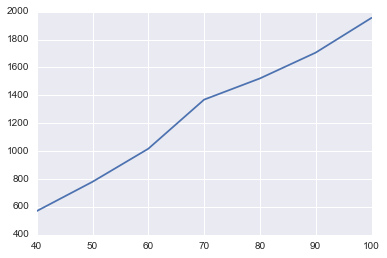

In [5]:
(pvals < 0.05).sum().plot()

In [6]:
(pvals < 0.05).sum()

40      570
50      780
60     1017
70     1369
80     1521
90     1706
100    1955
dtype: int64

## pwr

In [7]:
cluster_setup = False

In [8]:
def pwr(df, u, v):
    """
    Execute pwr.f2.test. The dataframe df must have a column f2.
    """
    import rpy2.robjects as ro
    ro.r('suppressPackageStartupMessages(library(pwr))')
    ro.globalenv['df'] = df
    ro.globalenv['u'] = u
    ro.globalenv['v'] = v
    ro.r('p = rep(1, dim(df)[2])')
    ro.r('for(i in 1:dim(df)[1]) {'
         'p[i] = pwr.f2.test(u=u, v=v, f2=df[i, "f2"], '
         'sig.level=0.001, power=NULL)["power"]}')
    p = ro.globalenv['p']
    power = [x[0] for x in p]
    return power

Here's an example of using `pwr.f2.test`.

In [ ]:
%%R

suppressPackageStartupMessages(library(pwr))
pwr.f2.test(u=2, v=117, f2=0.060995, sig.level=0.00000001, power=NULL)


     Multiple regression power calculation 

              u = 2
              v = 117
             f2 = 0.060995
      sig.level = 1e-08
          power = 0.0002883615



### Geuvadis

In [ ]:
url = ('ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/'
       'GEUV/E-GEUV-1/analysis_results/EUR373.gene.cis.FDR5.all.rs137.txt.gz')
fn = os.path.join(private_outdir, 'EUR373.gene.cis.FDR5.all.rs137.txt')
if not os.path.exists(fn):
    !curl {url} > {fn + '.gz'}
    !gunzip {fn + '.gz'}

geuvadis_fn = os.path.join(outdir, 'geuvadis.tsv')
if not os.path.exists(geuvadis_fn):
    geuvadis = pd.read_table(os.path.join(private_outdir, 'EUR373.gene.cis.FDR5.all.rs137.txt'), 
                             low_memory=False)
    # Remove genes that I didn't test.
    geuvadis['ens_gene_id'] = geuvadis.GENE_ID.apply(lambda x: x.split('.')[0])
    tested = pd.DataFrame(True, index=[x.split('.')[0] for x in exp.index], columns=['tested'])
    geuvadis = geuvadis.merge(tested, left_on='ens_gene_id', right_index=True)
    # Remove indels.
    geuvadis = geuvadis[geuvadis.SNPpos - geuvadis.SNPpos.astype(int) == 0]
    snps = geuvadis[['SNP_ID', 'CHR_SNP', 'SNPpos']]
    snps = snps.drop_duplicates()
    snps.CHR_SNP = snps.CHR_SNP.astype(int).astype(str)
    snps.index = snps.CHR_SNP + ':' + snps.SNPpos.astype(int).astype(str)
    # There are a few positions that still have indels. I'll drop any position
    # where there are two entries to fix this.
    vc = pd.Series(snps.index).value_counts()
    vc = vc[vc == 1]
    snps = snps.ix[vc.index]
    
    from ipyparallel import Client
    parallel_client = Client(profile='parallel')
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))

    with dview.sync_imports():
        import numpy
        import vcf

    %px np = numpy
    %px pyvcf = vcf

    def calc_stdev(chrom, pos):
        res = vcf_reader.fetch(chrom, pos, pos)
        try:
            r = res.next()
            out = np.std([0] * r.num_hom_ref + [1] * r.num_het + [2] * r.num_hom_alt)
        except:
            out = np.nan
        return '{}:{}'.format(chrom, int(pos)), out

    dview.push(dict(calc_stdev=calc_stdev))
    
    %px fn = ('/projects/CARDIPS/analysis/cardips-ipsc-eqtl/private_output/eqtl_input/filtered_all/0000.vcf.gz')
    %px vcf_reader = pyvcf.Reader(open(fn))
    
    cluster_setup = True
    
    stdev = dview.map_sync(lambda x: calc_stdev(x[0], x[1]), snps[['CHR_SNP', 'SNPpos']].values)
    tdf = pd.DataFrame(stdev, columns=['ind', 'genotype_stdev'])
    tdf.index = tdf.ind
    snps = snps.join(tdf)
    geuvadis = geuvadis.merge(snps[['SNP_ID', 'genotype_stdev']])
    geuvadis['r2'] = geuvadis.rvalue ** 2
    geuvadis = geuvadis.dropna(subset=['genotype_stdev'])
    geuvadis['f2'] = geuvadis.r2 / (1 - geuvadis.r2)
    
    for v in list(np.arange(40, rna_meta.in_unrelateds.sum(), 10)) + [rna_meta.in_unrelateds.sum()]:
        p = pwr(df=geuvadis, u=2, v=v - 1)
        geuvadis['power_{}'.format(v)] = p
    geuvadis.to_csv(geuvadis_fn, sep='\t')

Cluster has 250 engines.
importing numpy on engine(s)
importing vcf on engine(s)

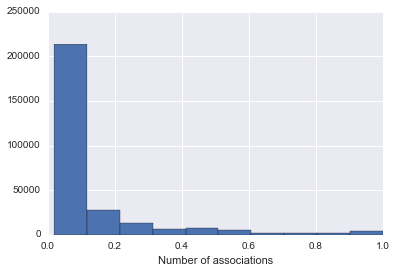

In [22]:
geuvadis.power_40.hist()
plt.xlabel('Power')
plt.xlabel('Number of associations');

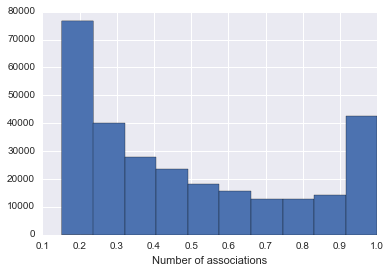

In [23]:
geuvadis.power_118.hist()
plt.xlabel('Power')
plt.xlabel('Number of associations');

Now I need to read the results for each gene and see whether I tested the
particular SNV and what my $p$-value was. One tricky part is that some Gencode
IDs are different between the Geuvadis results and my results, but they just 
differ by what is after the period. I'll make a mapping.

In [ ]:
geuvadis_genes = pd.DataFrame(geuvadis.GENE_ID.values, 
                              index=geuvadis.GENE_ID.apply(lambda x: x.split('.')[0]),
                              columns=['geuvadis']).drop_duplicates()
my_genes = pd.DataFrame(list(exp.index), 
                        index=[x.split('.')[0] for x in exp.index],
                        columns=['ipsc']).drop_duplicates()
gene_conv = geuvadis_genes.join(my_genes, how='inner')
gene_conv['ens'] = gene_conv.index
gene_conv.index = gene_conv.geuvadis

In [ ]:
for i in [40, 50, 60, 70, 80]:
    col = 'sig_{}'.format(i)
    geuvadis[col] = np.nan
    dy = os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis',
                      'unrelated_eqtls_{}'.format(i), 'gene_results')
    genes = list(set(geuvadis.GENE_ID))
    for gene in genes:
        fn = os.path.join(dy, gene_conv.ix[gene, 'ipsc'], '{}.tsv'.format(gene_conv.ix[gene, 'ipsc']))
        res = ciepy.read_emmax_output(fn)
        res.index = res.CHROM.astype(str) + ':' + res.BEG.astype(str)
        t = geuvadis[geuvadis.GENE_ID == gene]
        t['ind'] = t.index
        t.index = t.CHR_SNP.astype(str) + ':' + t.SNPpos.astype(int).astype(str)
        t = t.ix[set(res.index) & set(t.index)]
        res = res.ix[t.index]
        geuvadis.ix[t.ind, col] = (res.PVALUE < 0.001).values

In [ ]:
def power_plot(i):
    c = pd.cut(geuvadis['power_{}'.format(i)], np.arange(0, 1.01, 0.01))
    geuvadis['power_{}_bin'.format(i)] = c
    df = pd.crosstab(geuvadis['power_{}_bin'.format(i)], geuvadis['sig_{}'.format(i)])
    df['percent'] = df[True] / df.sum(axis=1)
    df.percent.plot()
    plt.title(i);

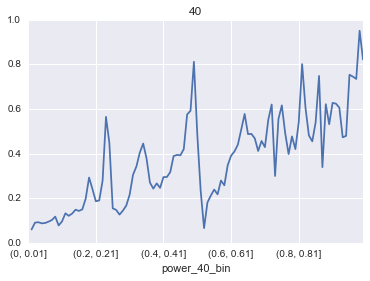

In [24]:
power_plot(40)

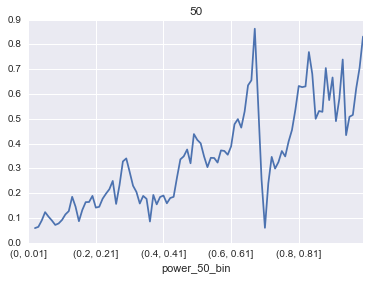

In [25]:
power_plot(50)

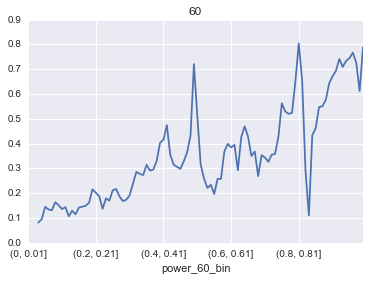

In [29]:
power_plot(60)

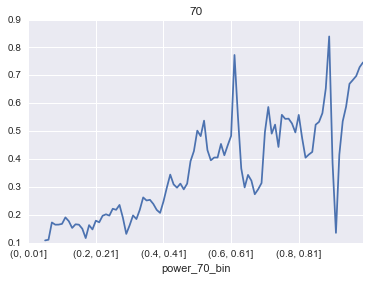

In [30]:
power_plot(70)

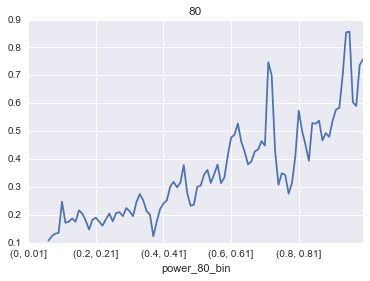

In [31]:
power_plot(80)

### GTEx

In [ ]:
fns = glob.glob(os.path.join(outdir, 'gtex_*tsv'))
if len(fns) != len(gtex_results.keys()):
    snps = []
    for k in gtex_results.keys():
        t = gtex_results[k]
        t['indel'] = False
        t.ix[[x[-1] == 'I' or x[-1] == 'D' for x in t.index], 'indel'] = True
        t = t[t.indel == False]
        snps.append(t[['SNP_Chr', 'SNP_Pos']])
        gtex_results[k] = t
    snps = pd.concat(snps)
    snps = snps.drop_duplicates()
    snps.index = (snps.SNP_Chr.astype(str) + ':' + snps.SNP_Pos.astype(str))

    geuvadis_snps = geuvadis[['CHR_SNP', 'SNPpos', 'genotype_stdev']]
    geuvadis_snps.index = (geuvadis_snps.CHR_SNP.astype(str) + ':' + 
                           geuvadis_snps.SNPpos.astype(int).astype(str))
    geuvadis_snps = geuvadis_snps.drop_duplicates()
    
    snps['genotype_stdev'] = np.nan
    ind = list(set(snps.index) & set(geuvadis_snps.index))
    snps.ix[ind, 'genotype_stdev'] = geuvadis_snps.ix[ind, 'genotype_stdev']    
    snps_todo = snps[snps.genotype_stdev.isnull()]

    from ipyparallel import Client
    parallel_client = Client(profile='parallel')
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    
    if cluster_setup == False:

        with dview.sync_imports():
            import numpy
            import vcf

        %px np = numpy
        %px pyvcf = vcf

        def calc_stdev(chrom, pos):
            res = vcf_reader.fetch(chrom, pos, pos)
            try:
                r = res.next()
                out = np.std([0] * r.num_hom_ref + [1] * r.num_het + [2] * r.num_hom_alt)
            except:
                out = np.nan
            return '{}:{}'.format(chrom, int(pos)), out

        dview.push(dict(calc_stdev=calc_stdev))

        %px fn = ('/projects/CARDIPS/analysis/cardips-ipsc-eqtl/private_output/eqtl_input/filtered_all/0000.vcf.gz')
        %px vcf_reader = pyvcf.Reader(open(fn))

        cluster_setup = True

    stdev = dview.map_sync(lambda x: calc_stdev(x[0], x[1]), snps_todo[['SNP_Chr', 'SNP_Pos']].values)
    tdf = pd.DataFrame(stdev, columns=['ind', 'genotype_stdev'])
    tdf.index = tdf.ind
    snps_todo['genotype_stdev'] = tdf.ix[snps_todo.index, 'genotype_stdev']
    snps.ix[snps_todo.index, 'genotype_stdev'] = snps_todo.genotype_stdev
    snps = snps[snps.genotype_stdev.isnull() == False]
    
    for k in gtex_results.keys():
        t = gtex_results[k]
        t.location = t.SNP_Chr.astype(str) + ':' + t.SNP_Pos.astype(str)
        t['genotype_stdev'] = snps.ix[t.location, 'genotype_stdev'].values
        t = t.dropna(subset=['genotype_stdev'])
        t['r2'] = (t.Beta * t.genotype_stdev)**2
        t['f2'] = t.r2 / (1 - t.r2)
        gtex_results[k] = t
    
    for k in gtex_results.keys():
        df = gtex_results[k]
        df = df[df.f2 > 0]
        for v in list(np.arange(40, rna_meta.in_unrelateds.sum(), 10)) + [rna_meta.in_unrelateds.sum()]:
            p = pwr(df=df, u=2, v=v - 1)
            df['power_{}'.format(v)] = p
        gtex_results[k] = df
        df.to_csv(os.path.join(outdir, 'gtex_{}.tsv'.format(k)))

In [56]:
gtex_results['Thyroid'].head()

,SNP_Chr,SNP_Pos,Gen_ID,Gene_Name,Gene_Pos,T_Stat,Beta,P_Val,min(p),EmpP,...,f2,power_40,power_50,power_60,power_70,power_80,power_90,power_100,power_110,power_118
SNP,,,,,,,,,,,,,,,,,,,,,
rs66542816,7,43287709,ENSG00000002746.9,HECW1,43152198,5.418705,0.695769,4.972608e-07,3.797184e-07,0.0003,...,0.235140,0.245663,0.376226,0.507857,0.628014,0.729529,0.810097,0.870803,0.914574,0.939783
rs6975079,7,43287061,ENSG00000002746.9,HECW1,43152198,5.425257,0.696020,4.837133e-07,3.797184e-07,0.0003,...,0.235463,0.246265,0.377053,0.508820,0.629008,0.730466,0.810914,0.871474,0.915098,0.940199
rs11972506,7,150496668,ENSG00000002933.3,TMEM176A,150498622,6.286991,0.553353,1.137610e-08,1.137610e-08,0.0001,...,0.186189,0.159973,0.253199,0.356622,0.462000,0.562458,0.653199,0.731565,0.796714,0.839603
rs112233725,16,89693191,ENSG00000003249.9,DBNDD1,90085881,5.161939,0.855898,1.449940e-06,1.094842e-07,0.0003,...,0.087410,0.038694,0.061225,0.089357,0.122780,0.160951,0.203155,0.248564,0.296294,0.335552
rs146972365,16,90022693,ENSG00000003249.9,DBNDD1,90085881,5.380679,0.940582,5.835382e-07,1.094842e-07,0.0003,...,0.083070,0.035322,0.055666,0.081100,0.111414,0.146196,0.184877,0.226777,0.271154,0.307924


In [59]:
gtex_genes = set()
for t in gtex_results.values():
    gtex_genes |= set(t.Gen_ID)

In [62]:
gtex_genes = list(gtex_genes)
gtex_genes = pd.DataFrame(gtex_genes, 
                          index=[x.split('.')[0] for x in gtex_genes],
                          columns=['gtex']).drop_duplicates()
my_genes = pd.DataFrame(list(exp.index), 
                        index=[x.split('.')[0] for x in exp.index],
                        columns=['ipsc']).drop_duplicates()
gtex_gene_conv = gtex_genes.join(my_genes, how='inner')
gtex_gene_conv['ens'] = gtex_gene_conv.index
gtex_gene_conv.index = gtex_gene_conv.gtex

In [108]:
my_genes.shape

(18556, 1)

In [107]:
gtex_gene_conv.shape

(5690, 3)

In [128]:
gtex_sig = []
for t in gtex_results.values():
    tt = t.SNP_Chr.astype(str) + ':' + t.SNP_Pos.astype(str) + ':' + t.Gen_ID
    tt.index = t.Gen_ID
    gtex_sig.append(tt)
gtex_sig = pd.concat(gtex_sig).drop_duplicates()
gtex_sig = gtex_sig.ix[gtex_gene_conv.index]

In [141]:
my_gtex_results = pd.DataFrame(index=gtex_sig.values)

In [ ]:
for i in [40, 50, 60, 70, 80, 90]:
    col = 'sig_{}'.format(i)
    geuvadis[col] = np.nan
    dy = os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis',
                      'unrelated_eqtls_{}'.format(i), 'gene_results')
    for gene in set(gtex_sig.index):
        fn = os.path.join(dy, gtex_gene_conv.ix[gene, 'ipsc'], '{}.tsv'.format(gtex_gene_conv.ix[gene, 'ipsc']))
        res = ciepy.read_emmax_output(fn)
        res.index = res.CHROM.astype(str) + ':' + res.BEG.astype(str) + ':' + gene
        t = gtex_sig.ix[gene]
        if type(t) == str:
            ind = [t]
        else:
            ind = t.values
        ind = set(res.index) & set()
        res = res.ix[ind]
        my_gtex_results.ix[ind, col] = (res.PVALUE < 0.001).values